In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import ArcGIS
import re
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

In [72]:
#https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

#df=pd.read_csv('road_accidents-2020.csv',usecols=['accident_index', 'accident_year', 
#'longitude','latitude', 'accident_severity', 'number_of_vehicles','number_of_casualties', 
#'date', 'day_of_week', 'time','road_type', 'speed_limit', 'junction_detail', 'junction_control',
#       'pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities', 'light_conditions',
#       'weather_conditions', 'road_surface_conditions','special_conditions_at_site', 'carriageway_hazards',
#       'urban_or_rural_area'],parse_dates=['date'],nrows=16000)

df=pd.read_csv('road_accidents-2020_with_postcode.csv',parse_dates=['date'])
df.reset_index(inplace=True)
print(df.columns)
df = df.dropna(axis=0)

#print(df.select_dtypes(include=['float64']).replace([np.inf, -np.inf], np.nan).isnull().sum())
df=df.drop(['longitude','latitude'],axis=1)


Index(['level_0', 'Unnamed: 0', 'index', 'accident_index', 'accident_year',
       'longitude', 'latitude', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time', 'road_type',
       'speed_limit', 'junction_detail', 'junction_control',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'address', 'postcode'],
      dtype='object')


15947


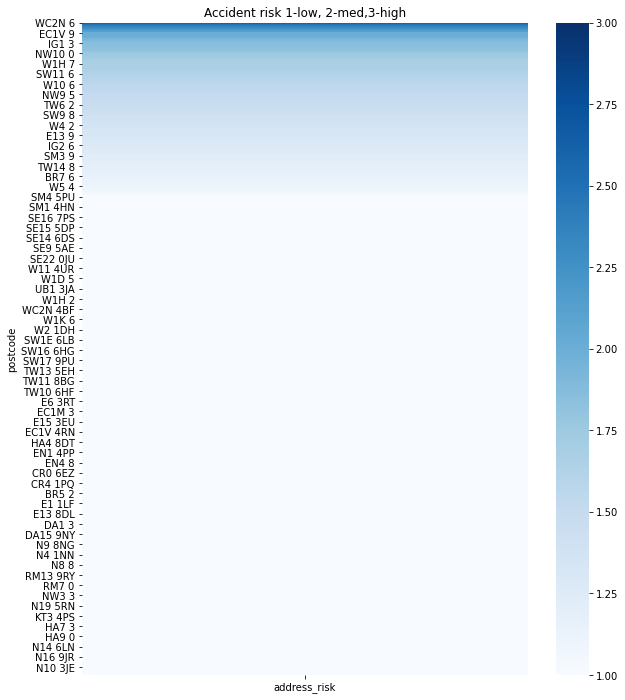

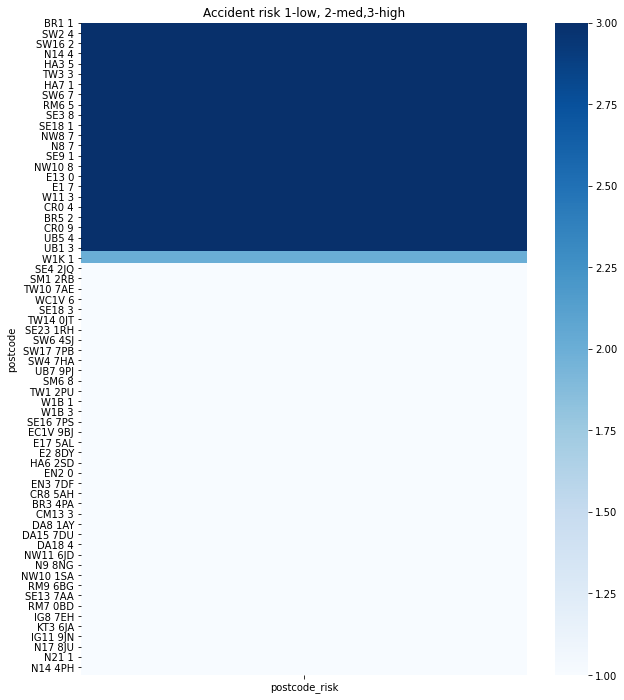

In [73]:
total_accidents=len(df)
print(total_accidents)
def RiskTranche(x):
    retVal=-1
    if x>0.05:
        retVal=3
    elif x>0.04 and x<=0.0499:
        retVal=2
    elif  x>=0 and x<=0.03999:
        retVal=1
    return retVal

df['postcode_risk'] = df.groupby('postcode')['accident_index'].transform('count').apply(lambda x:x/total_accidents*100).apply(RiskTranche)
df['address_risk'] = df.groupby('address')['accident_index'].transform('count').apply(lambda x:x/total_accidents*100).apply(RiskTranche)
#print(df)
pivot = df.pivot_table(index=['postcode'],values=['address_risk'],aggfunc='mean').sort_values(by=['address_risk'],ascending=False)
fig,ax=plt.subplots(figsize=(10,12))
sns.heatmap(pivot,cmap="Blues",ax=ax)
plt.title("Accident risk 1-low, 2-med,3-high")
plt.show()
pivot = df.pivot_table(index=['postcode'],values=['postcode_risk'],aggfunc='mean').sort_values(by=['postcode_risk'],ascending=False)
fig,ax=plt.subplots(figsize=(10,12))
sns.heatmap(pivot,cmap="Blues",ax=ax)
plt.title("Accident risk 1-low, 2-med,3-high")
plt.show()

#ax.hist(pivot)

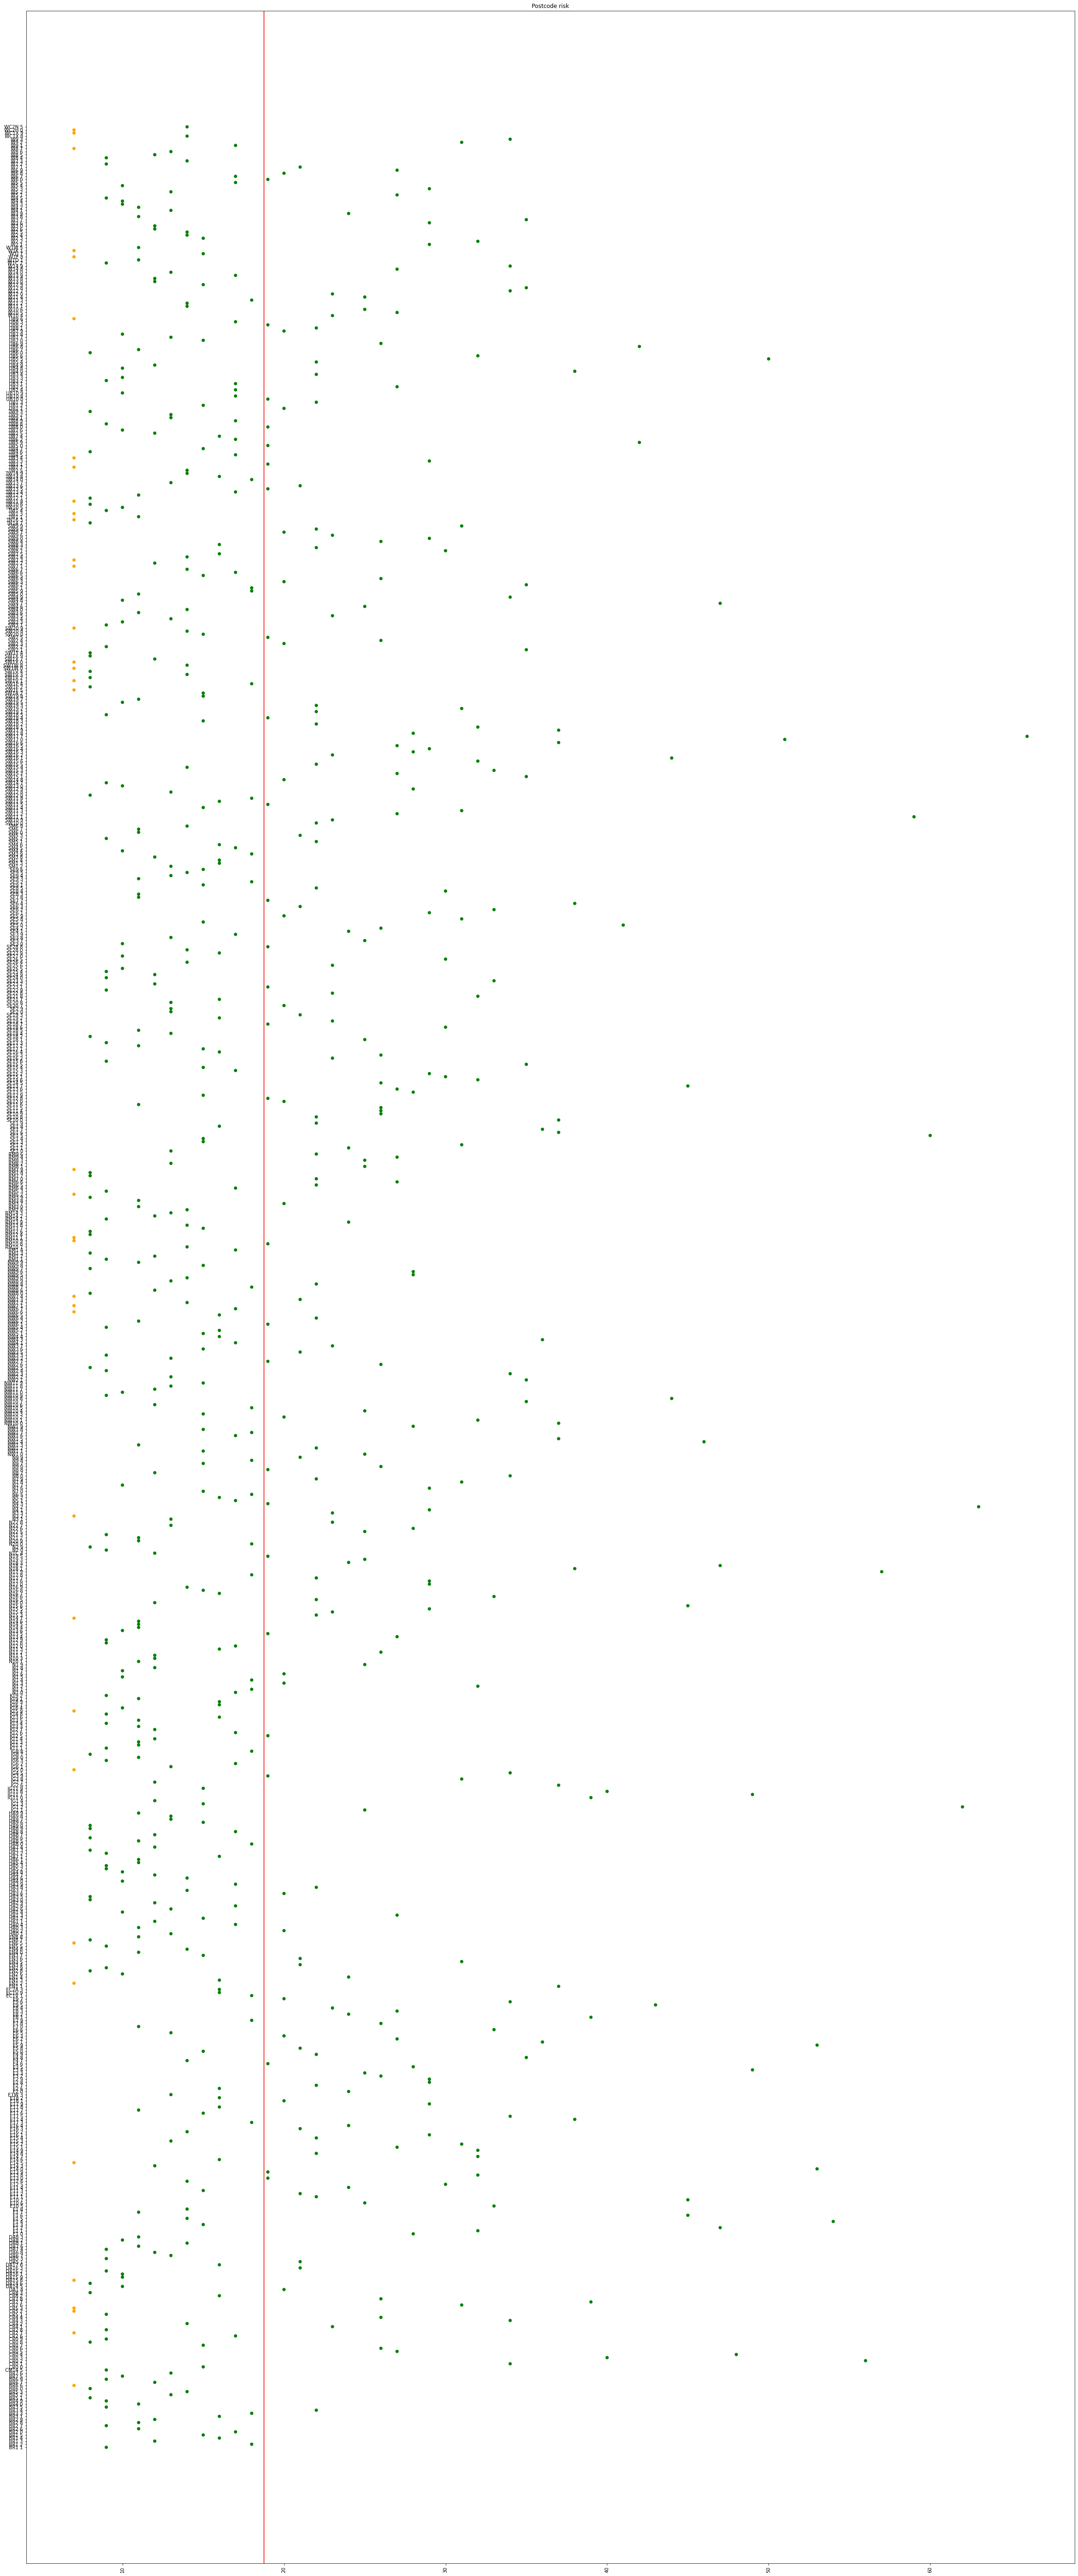

751


In [74]:
filter=df['postcode_risk'].isin([2,3])
grouped=df[filter].groupby(['postcode','postcode_risk'])['postcode_risk'].count()

colors = {1:'blue',2:'orange',3:'green'}
fig,ax = plt.subplots(figsize=(40,100))

postcodes=grouped.index.get_level_values(0)
risk=grouped.index.get_level_values(1)
values=grouped.values
ax.scatter(values,postcodes,c=[colors[x] for x in risk])
plt.axvline(x=values.mean(),
            color='red')
#sns.catplot(x=postcodes,y=values,height=35,aspect=.2)
plt.title('Postcode risk')
plt.xticks(rotation=90)
plt.show()
    
postcode_count=len(df[filter]['postcode'].unique())
print(postcode_count)

#for (con), d in df[filter].groupby(['postcode'], group_keys=False):
#    fig,ax = plt.subplots()
#    d.groupby('postcode_risk')['postcode_risk'].count().plot.bar(ax=ax)
#    ax.set_title(con)
#    plt.show()

In [75]:
df.drop(df[df['speed_limit'] == -1].index, inplace=True)
df.drop(df[df['weather_conditions'] == -1].index, inplace=True)
df.drop(df[df['road_surface_conditions'] == -1].index, inplace=True)

col='latitude'
df=df[df[col].notna() & (len(df[col])> 0)]

col='longitude'
df=df[df[col].notna() & (len(df[col])> 0)]

df[['accident_year','road_type','accident_severity','speed_limit']].value_counts().plot()
plt.xticks(rotation=90)
plt.show()

KeyError: 'latitude'

In [ ]:
pivot=pd.pivot_table(df,index=['weather_conditions'],
                             columns=['speed_limit'],
                             values=['number_of_casualties'],
                             aggfunc=np.sum)
#print(pivot)
#df[['weather_conditions','urban_or_rural_area','number_of_casualties']].value_counts().plot()
#plt.show()

plt.figure(figsize=(10,10))
sns.heatmap(pivot,annot=True, fmt="0.0f", linewidth=0.5, cbar=False,
              cmap="Reds", square=True)
plt.title('Casualities by weather conditions and speed')
plt.show()

In [ ]:
pivot=pd.pivot_table(df,index=['road_surface_conditions'],
                             columns=['speed_limit'],
                             values=['number_of_casualties'],
                             aggfunc=np.sum)
#print(pivot)
#df[['weather_conditions','urban_or_rural_area','number_of_casualties']].value_counts().plot()
#plt.show()

plt.figure(figsize=(10,10))
sns.heatmap(pivot,annot=True, fmt="0.0f", linewidth=0.5, cbar=False,
              cmap="Reds", square=True)
plt.show()

In [ ]:
df[df['special_conditions_at_site']!=0][['special_conditions_at_site']].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Special Conditions at site')
plt.show()

df[df['road_type']!=0][['road_type']].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Road Type')
plt.show()

df[['time']].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Time of Day')
plt.show()

#x=range(0,len(df[['urban_or_rural_area']].value_counts()))
#print(df[['urban_or_rural_area']].value_counts().values)
values=df[['urban_or_rural_area']].value_counts().values

#print(values)

plt.bar(['Rural','Urban'],values, color =['maroon','red'],
        width = 0.4)
plt.xticks(rotation=90)
plt.title('Urban or Rural')
plt.show()


In [76]:
#hmax.imshow(map_img,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 1) #put the map under the heatmap

#from matplotlib.pyplot import show 
#show()

In [77]:
count=0
def get_zipcode(df, geolocator, lat_field, lon_field):
    global count
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    #print(location.raw)
    retval1=None
    retval2=None
    #print(location.raw)
    if 'Address' in location.raw.keys():
        retval1=location.raw['Address']
        if count %100==0:
            print("{} {}".format(count,location.raw['Address']))
        
    if 'Postal' in location.raw.keys():
        retval2=location.raw['Postal']
    count+=1
    #time.sleep(1)
    return retval1,retval2


#geolocator = geopy.Nominatim(user_agent='myNishimoto')
geolocator =ArcGIS(scheme="https")

#series = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

#print(series)


In [78]:
#print(series)
#for key,item in series.items():
#    df.loc[key,'address']=item[0]
#    df.loc[key,'postcode']=item[1]
    
#df.to_csv('road_accidents-2020_with_postcode.csv')

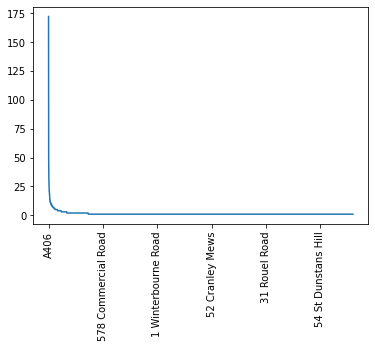

In [79]:
df['address'].value_counts().plot()
plt.xticks(rotation=90)
plt.show()

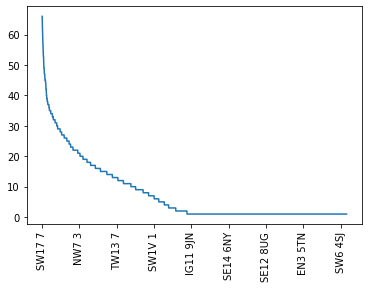

In [80]:
df['postcode'].value_counts().plot()
plt.xticks(rotation=90)
plt.show()

In [81]:
knn=KNeighborsClassifier(algorithm='auto',
                         leaf_size=30,
                         metric='minkowski',
                         metric_params=None,
                         n_jobs=1,
                         n_neighbors=3,
                         p=2,
                         weights='uniform')


x_columns=['number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'time', 'road_type',
       'speed_limit', 'junction_detail', 'junction_control',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'address', 'postcode','postcode_risk','address_risk']



y_column='accident_severity'
#y_column='number_of_casualties'
#number_of_casualties
X=df[x_columns]
y=df[y_column]

encoder=LabelEncoder()
X['time']=encoder.fit_transform(X['time'])
X['address']=encoder.fit_transform(X['address'])
X['postcode']=encoder.fit_transform(X['postcode'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(classification_report(y_test,y_pred))

#print(X)
#knn.fit(X,y)

train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)


# train_accuracy[index] = knn.score(X_train, y_train)

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8608/65676114.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time']=encoder.fit_transform(X['time'])
C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8608/65676114.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['address']=encoder.fit_transform(X['address'])
C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8608/65676114.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        30
           2       0.14      0.07      0.09       613
           3       0.87      0.94      0.90      4142

    accuracy                           0.82      4785
   macro avg       0.34      0.34      0.33      4785
weighted avg       0.77      0.82      0.79      4785



Text(0.5, 257.44, 'Predicted label')

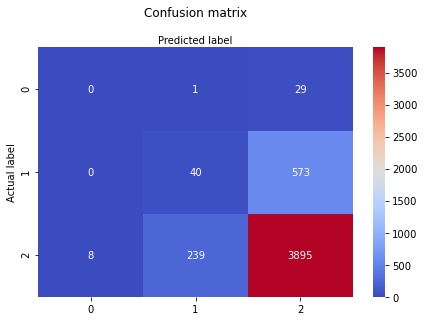

In [82]:
the_confusion_matrix=confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(the_confusion_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

No handles with labels found to put in legend.


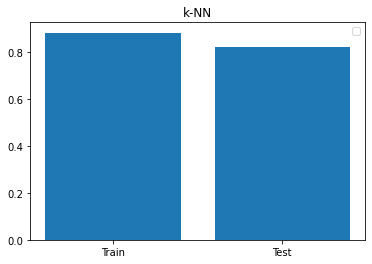

In [83]:
plt.title('k-NN')
plt.bar(x=['Train', 'Test'], height=[train_accuracy, test_accuracy])
plt.legend()
plt.show()


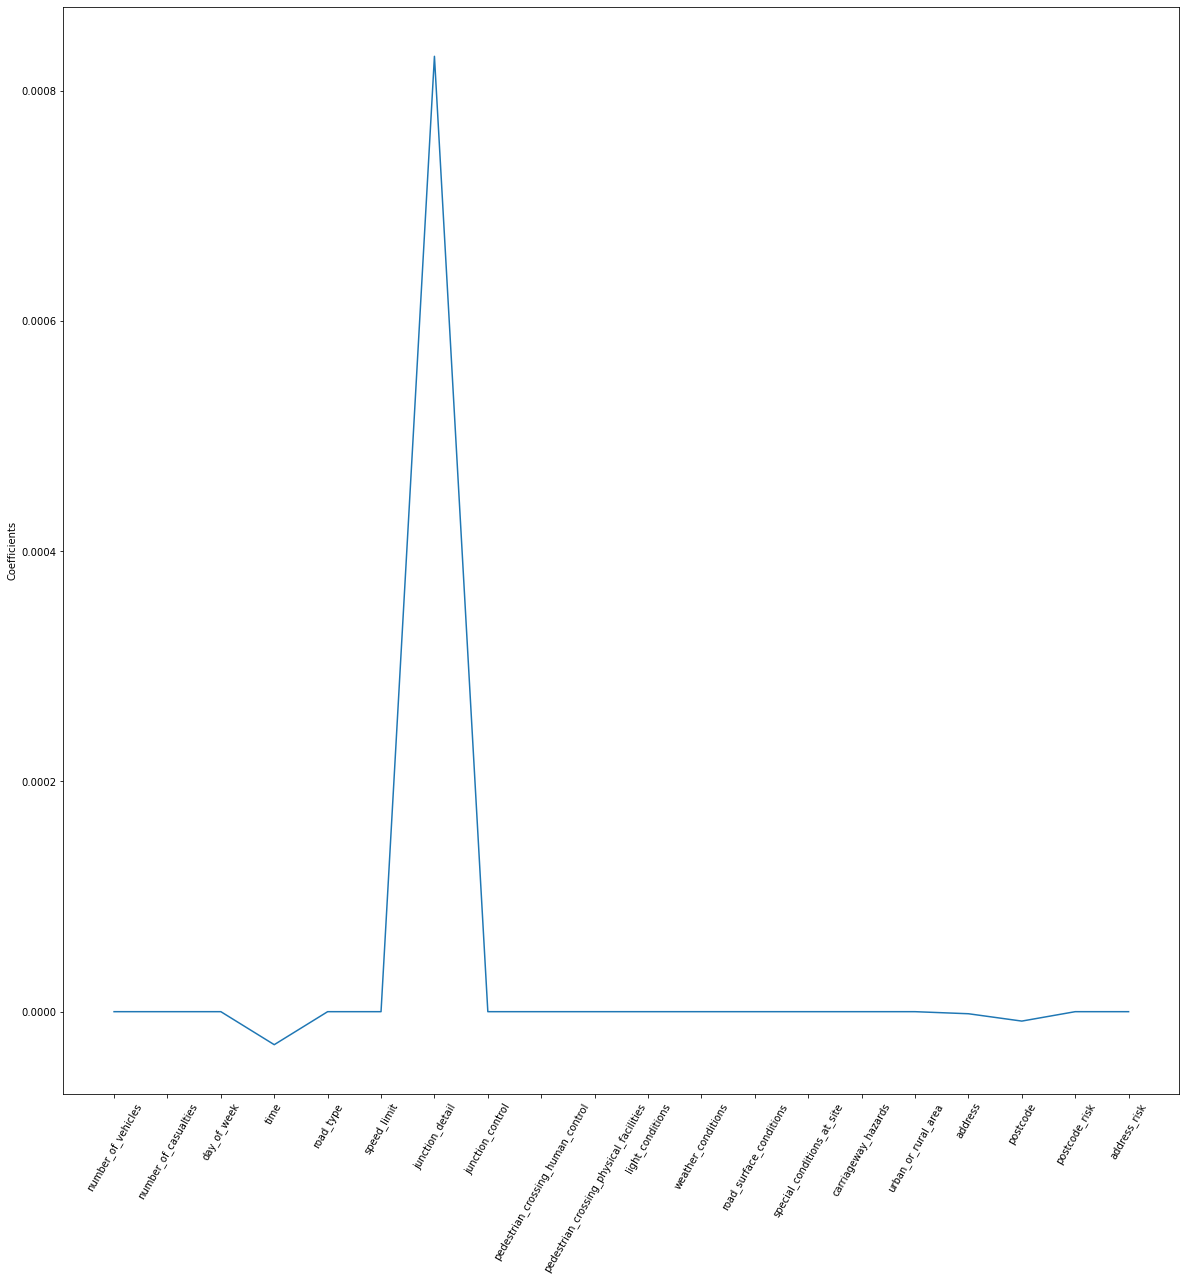

In [84]:
lasso=Lasso(alpha=0.1)
lasso_coef=lasso.fit(X,y).coef_

fig, ax = plt.subplots(figsize=(20,20))     
ax.plot(range(len(X.columns)),lasso_coef)
plt.xticks(range(len(X.columns)),X.columns,rotation=60)
plt.ylabel('Coefficients')
plt.show()

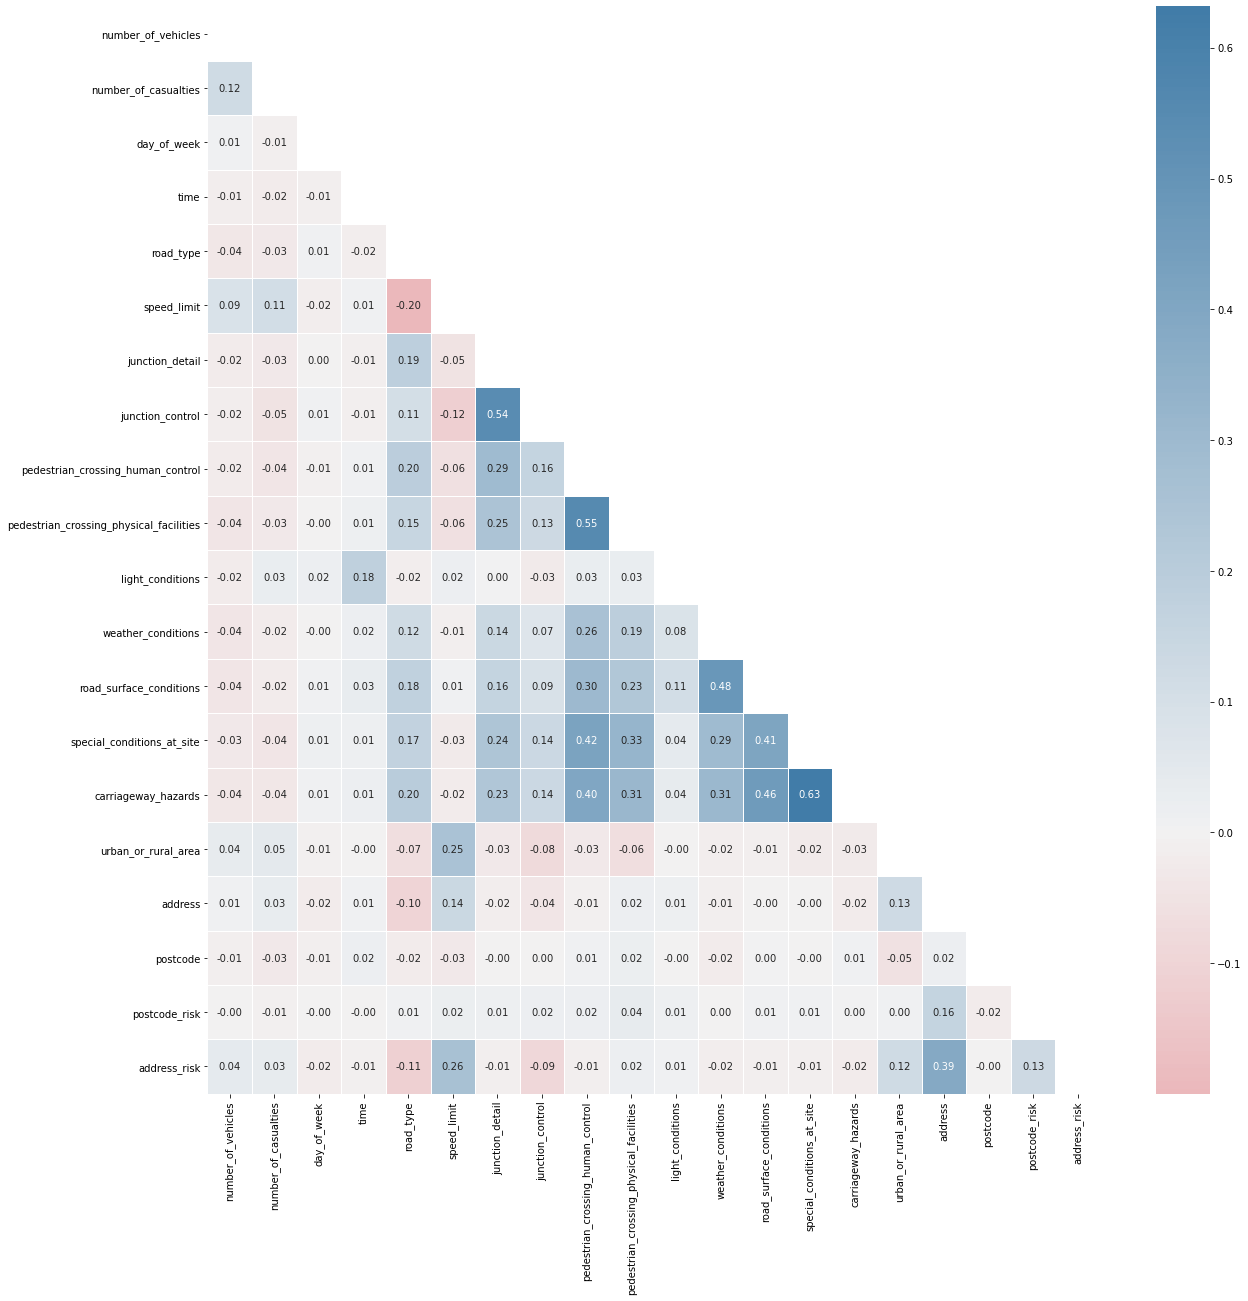

In [85]:
cmap=sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)


corr= X.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))

fig, ax = plt.subplots(figsize=(20,20))     

sns.heatmap(X.corr(), center=0, cmap=cmap, linewidths=1,
annot=True, fmt=".2f", ax=ax,mask=mask)
plt.show()

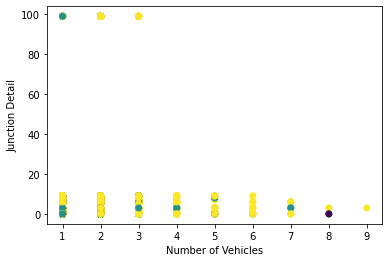

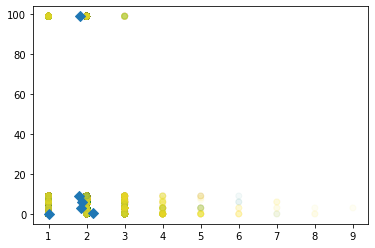

In [86]:
xs=df['number_of_vehicles']
ys=df['junction_detail']
color_labels=df['accident_severity']

_=plt.scatter(xs,ys,c=color_labels)
plt.xlabel('Number of Vehicles')
plt.ylabel('Junction Detail')
plt.show()

points=np.column_stack((xs,ys))


# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=6)

# Fit model to points
model.fit(points)

#print(model.inertia_)

new_points=np.random.permutation(points)

# Determine the cluster labels of new_points: labels
new_labels = model.predict(new_points)

# Print cluster labels of new_points
#print(new_labels)

xs = new_points[:,0]
ys = new_points[:,1]

plt.clf()
# Make a scatter plot of xs and ys, using labels to define the colors
_=plt.scatter(xs,ys,c=color_labels, alpha=0.05)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
_=plt.scatter(centroids_x,centroids_y, marker='D',s=50)
plt.show()

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


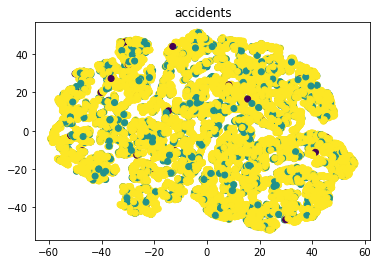

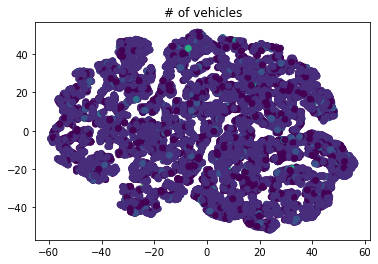

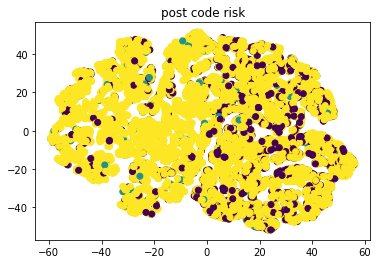

In [46]:
model=TSNE(learning_rate=50)
#numeric_df=df.select_dtypes(exclude='object')
numeric_df=X
#X=df.drop(non_numeric,axis=1)

#print(numeric_df.columns)

transformed=model.fit_transform(numeric_df)

xs=transformed[:,0]
ys=transformed[:,1]

color_labels=df['accident_severity']
plt.scatter(xs,ys,c=color_labels)
plt.title('accidents')
plt.show()

color_labels=df['number_of_vehicles']
plt.scatter(xs,ys,c=color_labels)
plt.title('# of vehicles')
plt.show()

color_labels=df['postcode_risk']
plt.scatter(xs,ys,c=color_labels)
plt.title('post code risk')
plt.show()

In [87]:
def circleOfCorrelations(pc_infos, series):
	plt.Circle((0,0),radius=10, color='g', fill=False)
	circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
	fig = plt.gcf()
	fig.gca().add_artist(circle1)
	for idx in range(len(pc_infos["PC-0"])):
		x = pc_infos["PC-0"][idx]
		y = pc_infos["PC-1"][idx]
		plt.plot([0.0,x],[0.0,y],'k-')
		plt.plot(x, y, 'rx')
		plt.annotate(pc_infos.index[idx], xy=(x,y))
	plt.xlabel("PC-0 (%s%%)" % str(series[0])[:4].lstrip("0."))
	plt.ylabel("PC-1 (%s%%)" % str(series[1])[:4].lstrip("0."))
	plt.xlim((-1,1))
	plt.ylim((-1,1))
	plt.title("Circle of Correlations")
 
def myScatter(df):
	# http://stackoverflow.com/a/23010837/1565438
	axs = pd.tools.plotting.scatter_matrix(df, diagonal='kde')
	for ax in axs[:,0]: # the left boundary
		ax.grid('off', axis='both')
		ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad=len(ax.get_ylabel())+40)
		ax.set_yticks([])
 
	for ax in axs[-1,:]: # the lower boundary
		ax.grid('off', axis='both')
		ax.set_xlabel(ax.get_xlabel(), rotation=90)
		ax.set_xticks([])
	plt.show()
 
def myPCA(df, title, clusters=None):
    # Normalize data
    df_norm = (df - df.mean()) / df.std()
    # PCA
    pca = PCA(n_components='mle')
    pca_res = pca.fit_transform(df_norm.values)
    series = pd.Series(pca.explained_variance_ratio_)
    series.plot(kind='bar', title=title)
    plt.show()
    # Circle of correlations
    # http://stackoverflow.com/a/22996786/1565438
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(series))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    circleOfCorrelations(pc_infos, series)
    plt.show()
    # Plot PCA
    dat = pd.DataFrame(pca_res, columns=cols)
    if isinstance(clusters, np.ndarray):
        for clust in set(clusters):
            colors = list("bgrcmyk")
            plt.scatter(dat["PC-0"][clusters==clust],dat["PC-1"][clusters==clust],c=colors[clust])
    else:
        plt.scatter(dat["PC-0"],dat["PC-1"])
    plt.xlabel("PC-0 (%s%%)" % str(series[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(series[1])[:4].lstrip("0."))
    plt.title("PCA")
    plt.show()
    return pc_infos, series

In [88]:
pc_infos, series=myPCA(df[x_columns],"Accident severity prediction")
#print(df.columns[0])

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8608/2156942293.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_norm = (df - df.mean()) / df.std()


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').